# Arrival Time Prediction - Prediction
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import scale
import time
import pickle
import tensorflow as tf
import gp_gpy as gp

sns.set(style="darkgrid")
np.random.seed(1)
data = pd.read_pickle('train.pkl')
travel_times = pd.read_pickle('travel_times.pkl')
n_segs = data.seg.unique()
synch_traj_n = 7 # traj 7 was used to train synch gps
route_n = 3 # all data used currently is from route 3

# These guys are not used as of now since all data comes from one route and one traj
def load_synch_gps(data):
    n_routes = [route_n] # should be computed from the data when all is done
    return {route_n: load_route_synch_gps(route_n) for route_n in n_routes}

def load_route_synch_gp(data, route_n):
    n_trajs = data.traj.unique()
    return {traj_n: load_traj_synch_gps(data[data.traj == traj_n], route_n, traj_n) for traj_n in n_trajs}

def load_traj_synch_gps(data, route_n, traj_n):
    n_segs = data.seg.unique()
    return {seg_n: load_seg_synch_gp(data[data.seg == seg_n], route_n, traj_n, seg_n) for seg_n in n_segs}
    
# This guy is used though
def load_seg_synch_gp(data, route_n, traj_n, seg_n):
    return gp.load(data, ['lat', 'lon'], ['progress'], 'synch', route_n, traj_n, seg_n)
    
n_segs = data.seg.unique()
synch_gps = {seg_n: load_seg_synch_gp(data, route_n, synch_traj_n, seg_n) for seg_n in n_segs}

## Training
With all that loaded we will now fit one GP for each segment in each trajectory. The function we want to fit is $f : \tau \mapsto \mathcal{R}^2$, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajecotry. As you might guess, this will take a while.

            lat        lon  progress  seg  speed  traj       tau  \
1772  15.571004  58.414219  1.000000  1.0  -1.00   4.0  0.081185   
1773  15.571004  58.414219  1.000000  1.0  -1.00   4.0  0.081185   
1774  15.571004  58.414219  1.000000  1.0  -1.00   4.0  0.081185   
1775  15.571198  58.414169  0.663102  1.0  -1.00   4.0  0.014591   
1776  15.571003  58.414215  0.668449  1.0   0.20   4.0  0.073208   
1777  15.571071  58.414185  0.695187  1.0   1.18   4.0  0.027201   
1778  15.571150  58.414169  0.705882  1.0   2.16   4.0  0.015010   
1779  15.571251  58.414169  0.716578  1.0   2.41   4.0  0.014101   
1780  15.571342  58.414196  0.727273  1.0   2.52   4.0  0.032017   
1781  15.571400  58.414238  0.737968  1.0   2.52   4.0  0.095501   
1782  15.571425  58.414288  0.748663  1.0   2.52   4.0  0.287206   
1783  15.571420  58.414333  0.759358  1.0   2.46   4.0  0.695998   
1784  15.571365  58.414368  0.770053  1.0   2.46   4.0  1.120766   
1785  15.571280  58.414387  0.780749  1.0   2.41

Optimization restart 2/5, f = 496.015082078756
Optimization restart 3/5, f = 496.0150820697987
Optimization restart 4/5, f = 496.01508206946994
Optimization restart 5/5, f = 496.0150821613928
            lat        lon  progress  seg  speed  traj       tau  \
1772  15.571004  58.414219  1.000000  1.0  -1.00   4.0  0.081185   
1773  15.571004  58.414219  1.000000  1.0  -1.00   4.0  0.081185   
1774  15.571004  58.414219  1.000000  1.0  -1.00   4.0  0.081185   
1775  15.571198  58.414169  0.663102  1.0  -1.00   4.0  0.014591   
1776  15.571003  58.414215  0.668449  1.0   0.20   4.0  0.073208   
1777  15.571071  58.414185  0.695187  1.0   1.18   4.0  0.027201   
1778  15.571150  58.414169  0.705882  1.0   2.16   4.0  0.015010   
1779  15.571251  58.414169  0.716578  1.0   2.41   4.0  0.014101   
1780  15.571342  58.414196  0.727273  1.0   2.52   4.0  0.032017   
1781  15.571400  58.414238  0.737968  1.0   2.52   4.0  0.095501   
1782  15.571425  58.414288  0.748663  1.0   2.52   4.0  0.28

Optimization restart 4/5, f = 388.0458089579211
Optimization restart 5/5, f = 388.04580878113063
            lat        lon  progress  seg  speed  traj       tau  \
1825  15.564960  58.414566  0.018868  2.0   2.46   4.0  0.000765   
1826  15.564895  58.414551  0.056604  2.0   1.74   4.0  0.001134   
1827  15.564617  58.414410  0.339623  2.0  -1.00   4.0  0.002098   
1828  15.564899  58.414532  0.358491  2.0   0.72   4.0  0.000970   
1829  15.564819  58.414501  0.415094  2.0   2.21   4.0  0.001376   
1830  15.564726  58.414455  0.452830  2.0   3.90   4.0  0.001728   
1831  15.564617  58.414410  0.452830  2.0  -1.00   4.0  0.002098   
1832  15.564524  58.414371  0.490566  2.0   6.58   4.0  0.002195   
1833  15.564432  58.414333  0.509434  2.0   6.89   4.0  0.001846   
1834  15.564327  58.414291  0.528302  2.0   7.35   4.0  0.000774   
1835  15.564220  58.414249  0.547170  2.0   7.81   4.0 -0.001247   
1836  15.564105  58.414204  0.566038  2.0   8.23   4.0 -0.003824   
1837  15.563988  58

Optimization restart 3/5, f = 464.12605625651787
Optimization restart 4/5, f = 464.1260562678441
Optimization restart 5/5, f = 464.1260562533341
            lat        lon  progress  seg  speed  traj       tau  \
1861  15.559885  58.413105  0.000000  3.0  13.37   4.0 -0.012970   
1862  15.559680  58.413052  0.000000  3.0  -1.00   4.0 -0.012433   
1863  15.559474  58.412994  0.060606  3.0  13.42   4.0 -0.010056   
1864  15.559281  58.412945  0.090909  3.0  13.37   4.0 -0.011182   
1865  15.559089  58.412880  0.121212  3.0  12.91   4.0 -0.029755   
1866  15.558896  58.412819  0.151515  3.0  13.01   4.0 -0.069054   
1867  15.558702  58.412762  0.181818  3.0  12.96   4.0 -0.112328   
1868  15.558528  58.412689  0.212121  3.0  12.91   4.0 -0.157229   
1869  15.558345  58.412613  0.242424  3.0  13.16   4.0 -0.140510   
1870  15.558159  58.412544  0.272727  3.0  13.22   4.0 -0.030548   
1871  15.557973  58.412472  0.303030  3.0  13.47   4.0  0.132597   
1872  15.557792  58.412399  0.333333  3

Optimization restart 2/5, f = 488.42752687761765
Optimization restart 3/5, f = 488.42752312756267
Optimization restart 4/5, f = 488.4275231276541
Optimization restart 5/5, f = 488.4275231293808
            lat        lon  progress  seg  speed  traj       tau  \
1861  15.559885  58.413105  0.000000  3.0  13.37   4.0 -0.012970   
1862  15.559680  58.413052  0.000000  3.0  -1.00   4.0 -0.012433   
1863  15.559474  58.412994  0.060606  3.0  13.42   4.0 -0.010056   
1864  15.559281  58.412945  0.090909  3.0  13.37   4.0 -0.011182   
1865  15.559089  58.412880  0.121212  3.0  12.91   4.0 -0.029755   
1866  15.558896  58.412819  0.151515  3.0  13.01   4.0 -0.069054   
1867  15.558702  58.412762  0.181818  3.0  12.96   4.0 -0.112328   
1868  15.558528  58.412689  0.212121  3.0  12.91   4.0 -0.157229   
1869  15.558345  58.412613  0.242424  3.0  13.16   4.0 -0.140510   
1870  15.558159  58.412544  0.272727  3.0  13.22   4.0 -0.030548   
1871  15.557973  58.412472  0.303030  3.0  13.47   4.0  0.

Optimization restart 3/5, f = 334.39311116698985
Optimization restart 4/5, f = 334.39311116714055
Optimization restart 5/5, f = 334.39311116721376
            lat        lon  progress  seg  speed  traj       tau  \
1896  15.555891  58.409981  0.000000  4.0  12.70   4.0 -0.000081   
1897  15.555837  58.409760  0.000000  4.0  -1.00   4.0 -0.000139   
1898  15.555867  58.409874  0.043478  4.0  12.60   4.0 -0.000098   
1899  15.555837  58.409760  0.043478  4.0  -1.00   4.0 -0.000139   
1900  15.555816  58.409653  0.130435  4.0  12.19   4.0  0.001776   
1901  15.555791  58.409546  0.173913  4.0  11.83   4.0  0.012587   
1902  15.555765  58.409443  0.217391  4.0  11.67   4.0  0.145102   
1903  15.555742  58.409336  0.260870  4.0  11.57   4.0  0.615368   
1904  15.555723  58.409233  0.304348  4.0  11.52   4.0  0.693586   
1905  15.555703  58.409134  0.347826  4.0  11.42   4.0  0.317377   
1906  15.555686  58.409035  0.391304  4.0  11.42   4.0  0.619624   
1907  15.555676  58.408928  0.434783 

Optimization restart 1/5, f = 394.9755304469726
Optimization restart 2/5, f = 394.9755304470574
Optimization restart 3/5, f = 394.97553045653905
Optimization restart 4/5, f = 394.9755304469528
Optimization restart 5/5, f = 394.97553044733377
            lat        lon  progress  seg  speed  traj       tau  \
1922  15.555863  58.407482  0.000000  5.0  11.72   4.0 -1.189792   
1923  15.555918  58.407387  0.000000  5.0  -1.00   4.0 -2.199822   
1924  15.555981  58.407284  0.040000  5.0  11.78   4.0 -3.142504   
1925  15.556042  58.407185  0.060000  5.0  11.62   4.0 -3.188669   
1926  15.556110  58.407093  0.080000  5.0  11.47   4.0 -2.660225   
1927  15.556181  58.406998  0.100000  5.0  11.21   4.0 -2.125659   
1928  15.556254  58.406906  0.120000  5.0  10.95   4.0 -1.377489   
1929  15.556330  58.406818  0.140000  5.0  10.70   4.0  0.052217   
1930  15.556419  58.406734  0.160000  5.0  10.49   4.0  1.641536   
1931  15.556512  58.406658  0.180000  5.0  10.34   4.0  2.226060   
1932  15.5

Optimization restart 2/5, f = 632.5667443849104
Optimization restart 3/5, f = 630.3097331151018
Optimization restart 4/5, f = 630.3097331150959
Optimization restart 5/5, f = 630.3097331352366
            lat        lon  progress  seg  speed  traj       tau  \
1922  15.555863  58.407482  0.000000  5.0  11.72   4.0 -1.189792   
1923  15.555918  58.407387  0.000000  5.0  -1.00   4.0 -2.199822   
1924  15.555981  58.407284  0.040000  5.0  11.78   4.0 -3.142504   
1925  15.556042  58.407185  0.060000  5.0  11.62   4.0 -3.188669   
1926  15.556110  58.407093  0.080000  5.0  11.47   4.0 -2.660225   
1927  15.556181  58.406998  0.100000  5.0  11.21   4.0 -2.125659   
1928  15.556254  58.406906  0.120000  5.0  10.95   4.0 -1.377489   
1929  15.556330  58.406818  0.140000  5.0  10.70   4.0  0.052217   
1930  15.556419  58.406734  0.160000  5.0  10.49   4.0  1.641536   
1931  15.556512  58.406658  0.180000  5.0  10.34   4.0  2.226060   
1932  15.556619  58.406578  0.200000  5.0  10.28   4.0  1.70

Optimization restart 3/5, f = 581.9701154139284
Optimization restart 4/5, f = 581.9703656547664
Optimization restart 5/5, f = 581.9701270674947
            lat        lon  progress  seg  speed  traj       tau  \
1972  15.559734  58.406574  0.015873  6.0   4.57   4.0  0.171425   
1973  15.559812  58.406620  0.047619  6.0   3.13   4.0  0.207392   
1974  15.559863  58.406647  0.095238  6.0   0.00   4.0  0.212030   
1975  15.560029  58.406750  0.222222  6.0  -1.00   4.0 -0.107535   
1976  15.559887  58.406639  0.238095  6.0   0.77   4.0  0.239570   
1977  15.559928  58.406681  0.269841  6.0   3.18   4.0  0.179001   
1978  15.559975  58.406712  0.285714  6.0   4.52   4.0  0.089649   
1979  15.560029  58.406750  0.285714  6.0  -1.00   4.0 -0.107535   
1980  15.560097  58.406799  0.317460  6.0   6.53   4.0 -0.493360   
1981  15.560180  58.406849  0.333333  6.0   7.20   4.0 -0.899450   
1982  15.560275  58.406902  0.349206  6.0   7.92   4.0 -1.160515   
1983  15.560374  58.406956  0.365079  6.

Optimization restart 2/5, f = 689.0468905316017
Optimization restart 3/5, f = 689.0462777322978
Optimization restart 4/5, f = 689.0475992299195
Optimization restart 5/5, f = 689.0473020847035
            lat        lon  progress  seg  speed  traj        tau  \
2023  15.564855  58.407795  0.010638  7.0   3.85   4.0 -10.548795   
2024  15.564897  58.407749  0.031915  7.0   2.93   4.0 -10.714483   
2025  15.565114  58.407555  0.308511  7.0  -1.00   4.0  -6.231310   
2026  15.564847  58.407757  0.319149  7.0   0.20   4.0 -10.822960   
2027  15.564923  58.407711  0.361702  7.0   2.57   4.0 -10.616587   
2028  15.564973  58.407681  0.372340  7.0   3.90   4.0 -10.055247   
2029  15.565027  58.407639  0.382979  7.0   5.04   4.0  -8.989479   
2030  15.565114  58.407555  0.382979  7.0  -1.00   4.0  -6.231310   
2031  15.565172  58.407497  0.404255  7.0   6.94   4.0  -3.966682   
2032  15.565228  58.407440  0.414894  7.0   7.40   4.0  -1.700906   
2033  15.565291  58.407375  0.425532  7.0   7.87 

Optimization restart 1/5, f = 695.2447434896617
Optimization restart 2/5, f = 695.2447433630664
Optimization restart 3/5, f = 695.2447433484928
Optimization restart 4/5, f = 695.2447433557721
Optimization restart 5/5, f = 695.2447433576097
            lat        lon  progress  seg  speed  traj        tau  \
2023  15.564855  58.407795  0.010638  7.0   3.85   4.0 -10.548795   
2024  15.564897  58.407749  0.031915  7.0   2.93   4.0 -10.714483   
2025  15.565114  58.407555  0.308511  7.0  -1.00   4.0  -6.231310   
2026  15.564847  58.407757  0.319149  7.0   0.20   4.0 -10.822960   
2027  15.564923  58.407711  0.361702  7.0   2.57   4.0 -10.616587   
2028  15.564973  58.407681  0.372340  7.0   3.90   4.0 -10.055247   
2029  15.565027  58.407639  0.382979  7.0   5.04   4.0  -8.989479   
2030  15.565114  58.407555  0.382979  7.0  -1.00   4.0  -6.231310   
2031  15.565172  58.407497  0.404255  7.0   6.94   4.0  -3.966682   
2032  15.565228  58.407440  0.414894  7.0   7.40   4.0  -1.700906   
2

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 1/5, f = 402.7955227759378
Optimization restart 2/5, f = 402.7955227505226
Optimization restart 3/5, f = 402.79552275365427
Optimization restart 4/5, f = 402.79552275139696
Optimization restart 5/5, f = 402.79552275050037
            lat        lon  progress  seg  speed  traj       tau  \
2086  15.569813  58.405418  0.000000  8.0   3.75   4.0  0.859876   
2087  15.569901  58.405422  0.036364  8.0   2.21   4.0  1.171213   
2088  15.570128  58.405483  0.327273  8.0  -1.00   4.0 -0.834032   
2089  15.569898  58.405445  0.345455  8.0   0.25   4.0  0.058685   
2090  15.569974  58.405453  0.400000  8.0   2.26   4.0  0.042711   
2091  15.570067  58.405472  0.436364  8.0   2.98   4.0 -0.648657   
2092  15.570212  58.405499  0.472727  8.0   4.68   4.0 -0.653817   
2093  15.570369  58.405514  0.490909  8.0   6.73   4.0  0.357062   
2094  15.570493  58.405525  0.509091  8.0   7.30   4.0  0.734403   
2095  15.570627  58.405533  0.527273  8.0   7.71   4.0  0.516085   
2096  15.

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 1/5, f = 414.9577878068138
Optimization restart 2/5, f = 414.9577878088333
Optimization restart 3/5, f = 414.9577878042375
Optimization restart 4/5, f = 414.9577878042412
Optimization restart 5/5, f = 414.95779353808524
            lat        lon  progress  seg  speed  traj       tau  \
2086  15.569813  58.405418  0.000000  8.0   3.75   4.0  0.859876   
2087  15.569901  58.405422  0.036364  8.0   2.21   4.0  1.171213   
2088  15.570128  58.405483  0.327273  8.0  -1.00   4.0 -0.834032   
2089  15.569898  58.405445  0.345455  8.0   0.25   4.0  0.058685   
2090  15.569974  58.405453  0.400000  8.0   2.26   4.0  0.042711   
2091  15.570067  58.405472  0.436364  8.0   2.98   4.0 -0.648657   
2092  15.570212  58.405499  0.472727  8.0   4.68   4.0 -0.653817   
2093  15.570369  58.405514  0.490909  8.0   6.73   4.0  0.357062   
2094  15.570493  58.405525  0.509091  8.0   7.30   4.0  0.734403   
2095  15.570627  58.405533  0.527273  8.0   7.71   4.0  0.516085   
2096  15.57

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 1/5, f = 482.3980039123222
Optimization restart 2/5, f = 482.3980039005416
Optimization restart 3/5, f = 483.6787351368294


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 4/5, f = 482.39800389747694
Optimization restart 5/5, f = 482.39800389749956
            lat        lon  progress  seg  speed  traj        tau  \
2123  15.574696  58.405926  0.000000  9.0   4.11   4.0 -11.204916   
2124  15.574798  58.405930  0.013072  9.0   2.52   4.0 -10.952356   
2125  15.575042  58.406002  0.124183  9.0  -1.00   4.0  -9.048000   
2126  15.574816  58.405945  0.124183  9.0   0.00   4.0 -10.716358   
2127  15.574977  58.405987  0.156863  9.0   3.08   4.0  -9.560751   
2128  15.575042  58.406002  0.156863  9.0  -1.00   4.0  -9.048000   
2129  15.575117  58.406017  0.169935  9.0   4.21   4.0  -8.467231   
2130  15.575238  58.406029  0.176471  9.0   5.65   4.0  -7.738815   
2131  15.575336  58.406036  0.183007  9.0   5.86   4.0  -7.146944   
2132  15.575438  58.406048  0.189542  9.0   6.07   4.0  -6.445890   
2133  15.575551  58.406059  0.196078  9.0   6.68   4.0  -5.682623   
2134  15.575677  58.406067  0.202614  9.0   7.15   4.0  -4.909105   
2135 

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 5/5, f = 1331.6011338542367
            lat        lon  progress  seg  speed  traj        tau  \
2123  15.574696  58.405926  0.000000  9.0   4.11   4.0 -11.204916   
2124  15.574798  58.405930  0.013072  9.0   2.52   4.0 -10.952356   
2125  15.575042  58.406002  0.124183  9.0  -1.00   4.0  -9.048000   
2126  15.574816  58.405945  0.124183  9.0   0.00   4.0 -10.716358   
2127  15.574977  58.405987  0.156863  9.0   3.08   4.0  -9.560751   
2128  15.575042  58.406002  0.156863  9.0  -1.00   4.0  -9.048000   
2129  15.575117  58.406017  0.169935  9.0   4.21   4.0  -8.467231   
2130  15.575238  58.406029  0.176471  9.0   5.65   4.0  -7.738815   
2131  15.575336  58.406036  0.183007  9.0   5.86   4.0  -7.146944   
2132  15.575438  58.406048  0.189542  9.0   6.07   4.0  -6.445890   
2133  15.575551  58.406059  0.196078  9.0   6.68   4.0  -5.682623   
2134  15.575677  58.406067  0.202614  9.0   7.15   4.0  -4.909105   
2135  15.575805  58.406078  0.209150  9.0   7.66   4.0

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 1/5, f = 1594.3072116789072
Optimization restart 2/5, f = 1590.7129230042422
Optimization restart 3/5, f = 1590.7129230284818
Optimization restart 4/5, f = 1590.712923021063
Optimization restart 5/5, f = 1590.7129230038547
            lat        lon  progress   seg  speed  traj       tau  \
2251  15.589289  58.407021  0.028571  10.0   1.49   4.0  0.203597   
2252  15.589684  58.407085  0.271429  10.0  -1.00   4.0 -0.006725   
2253  15.589263  58.407028  0.285714  10.0   1.08   4.0  0.267136   
2254  15.589351  58.407036  0.314286  10.0   2.82   4.0  0.367417   
2255  15.589479  58.407055  0.342857  10.0   4.01   4.0  0.520663   
2256  15.589561  58.407070  0.357143  10.0   4.47   4.0  0.368606   
2257  15.589684  58.407085  0.357143  10.0  -1.00   4.0 -0.006725   
2258  15.589787  58.407097  0.385714  10.0   6.12   4.0 -0.244171   
2259  15.589891  58.407108  0.400000  10.0   6.01   4.0 -0.227349   
2260  15.590006  58.407116  0.414286  10.0   6.53   4.0  0.061583 

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 2/5, f = 516.3861497293587
Optimization restart 3/5, f = 516.3861497294349
Optimization restart 4/5, f = 545.7286537095613
Optimization restart 5/5, f = 516.3861497581883
            lat        lon  progress   seg  speed  traj       tau  \
2251  15.589289  58.407021  0.028571  10.0   1.49   4.0  0.203597   
2252  15.589684  58.407085  0.271429  10.0  -1.00   4.0 -0.006725   
2253  15.589263  58.407028  0.285714  10.0   1.08   4.0  0.267136   
2254  15.589351  58.407036  0.314286  10.0   2.82   4.0  0.367417   
2255  15.589479  58.407055  0.342857  10.0   4.01   4.0  0.520663   
2256  15.589561  58.407070  0.357143  10.0   4.47   4.0  0.368606   
2257  15.589684  58.407085  0.357143  10.0  -1.00   4.0 -0.006725   
2258  15.589787  58.407097  0.385714  10.0   6.12   4.0 -0.244171   
2259  15.589891  58.407108  0.400000  10.0   6.01   4.0 -0.227349   
2260  15.590006  58.407116  0.414286  10.0   6.53   4.0  0.061583   
2261  15.590125  58.407120  0.428571  10.0   7.20

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 2/5, f = 531.8849653736828
Optimization restart 3/5, f = 531.8849653731199
Optimization restart 4/5, f = 531.8849653730456
Optimization restart 5/5, f = 531.884965373671
            lat        lon  progress   seg  speed  traj       tau  \
2251  15.589289  58.407021  0.028571  10.0   1.49   4.0  0.203597   
2252  15.589684  58.407085  0.271429  10.0  -1.00   4.0 -0.006725   
2253  15.589263  58.407028  0.285714  10.0   1.08   4.0  0.267136   
2254  15.589351  58.407036  0.314286  10.0   2.82   4.0  0.367417   
2255  15.589479  58.407055  0.342857  10.0   4.01   4.0  0.520663   
2256  15.589561  58.407070  0.357143  10.0   4.47   4.0  0.368606   
2257  15.589684  58.407085  0.357143  10.0  -1.00   4.0 -0.006725   
2258  15.589787  58.407097  0.385714  10.0   6.12   4.0 -0.244171   
2259  15.589891  58.407108  0.400000  10.0   6.01   4.0 -0.227349   
2260  15.590006  58.407116  0.414286  10.0   6.53   4.0  0.061583   
2261  15.590125  58.407120  0.428571  10.0   7.20 

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 1/5, f = 617.8264796868211
Optimization restart 2/5, f = 617.8264797954662
Optimization restart 3/5, f = 617.8264807871828
Optimization restart 4/5, f = 617.8264796865627
Optimization restart 5/5, f = 647.169608543776
            lat        lon  progress   seg  speed  traj        tau  \
2301  15.596398  58.407372  0.028986  11.0   1.90   4.0  -7.668381   
2302  15.596784  58.407410  0.304348  11.0  -1.00   4.0 -19.673560   
2303  15.596431  58.407364  0.318841  11.0   0.41   4.0  -0.935903   
2304  15.596503  58.407375  0.362319  11.0   1.59   4.0  -5.475279   
2305  15.596611  58.407394  0.391304  11.0   3.34   4.0 -17.023568   
2306  15.596784  58.407410  0.405797  11.0  -1.00   4.0 -19.673560   
2307  15.596688  58.407402  0.405797  11.0   4.21   4.0 -19.529963   
2308  15.596784  58.407410  0.420290  11.0   5.14   4.0 -19.673560   
2309  15.596940  58.407421  0.434783  11.0   6.58   4.0 -16.190255   
2310  15.597063  58.407429  0.449275  11.0   7.04   4.0 -10.3

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 2/5, f = 464.52484707655117
Optimization restart 3/5, f = 464.5248470745767
Optimization restart 4/5, f = 464.5248474422526
Optimization restart 5/5, f = 464.5248472348361
            lat        lon  progress   seg  speed  traj        tau  \
2301  15.596398  58.407372  0.028986  11.0   1.90   4.0  -7.668381   
2302  15.596784  58.407410  0.304348  11.0  -1.00   4.0 -19.673560   
2303  15.596431  58.407364  0.318841  11.0   0.41   4.0  -0.935903   
2304  15.596503  58.407375  0.362319  11.0   1.59   4.0  -5.475279   
2305  15.596611  58.407394  0.391304  11.0   3.34   4.0 -17.023568   
2306  15.596784  58.407410  0.405797  11.0  -1.00   4.0 -19.673560   
2307  15.596688  58.407402  0.405797  11.0   4.21   4.0 -19.529963   
2308  15.596784  58.407410  0.420290  11.0   5.14   4.0 -19.673560   
2309  15.596940  58.407421  0.434783  11.0   6.58   4.0 -16.190255   
2310  15.597063  58.407429  0.449275  11.0   7.04   4.0 -10.369685   
2311  15.597192  58.407436  0.463768 

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 2/5, f = 477.7634187731927
Optimization restart 3/5, f = 477.76341877027835
Optimization restart 4/5, f = 477.7634187702822
Optimization restart 5/5, f = 477.7634187763812
            lat        lon  progress   seg  speed  traj        tau  \
2301  15.596398  58.407372  0.028986  11.0   1.90   4.0  -7.668381   
2302  15.596784  58.407410  0.304348  11.0  -1.00   4.0 -19.673560   
2303  15.596431  58.407364  0.318841  11.0   0.41   4.0  -0.935903   
2304  15.596503  58.407375  0.362319  11.0   1.59   4.0  -5.475279   
2305  15.596611  58.407394  0.391304  11.0   3.34   4.0 -17.023568   
2306  15.596784  58.407410  0.405797  11.0  -1.00   4.0 -19.673560   
2307  15.596688  58.407402  0.405797  11.0   4.21   4.0 -19.529963   
2308  15.596784  58.407410  0.420290  11.0   5.14   4.0 -19.673560   
2309  15.596940  58.407421  0.434783  11.0   6.58   4.0 -16.190255   
2310  15.597063  58.407429  0.449275  11.0   7.04   4.0 -10.369685   
2311  15.597192  58.407436  0.463768 

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Optimization restart 2/5, f = 551.1717955797892
Optimization restart 3/5, f = 551.1717964348179
Optimization restart 4/5, f = 551.1717955938258
Optimization restart 5/5, f = 551.1717955939167


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


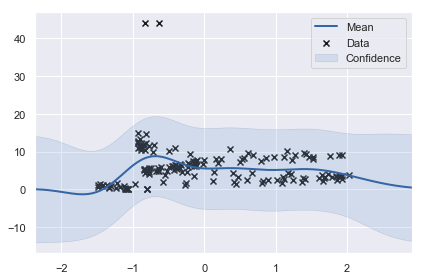

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


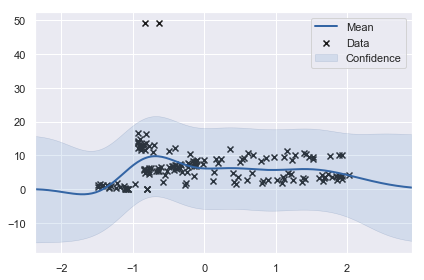

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


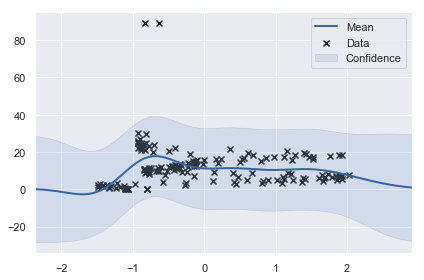

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


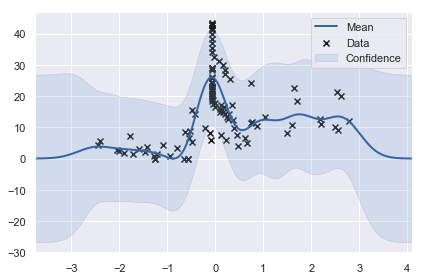

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


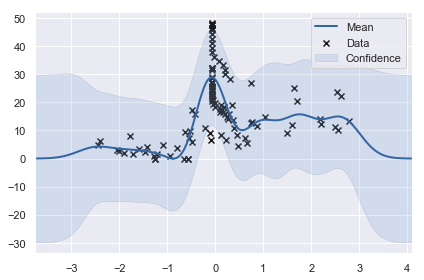

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


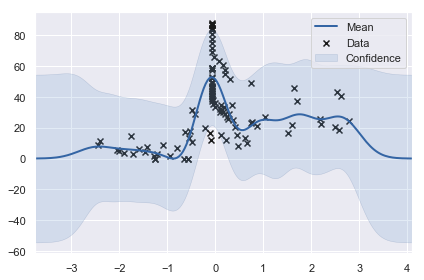

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


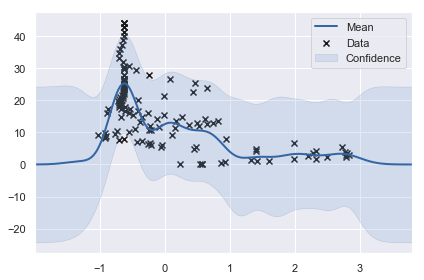

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


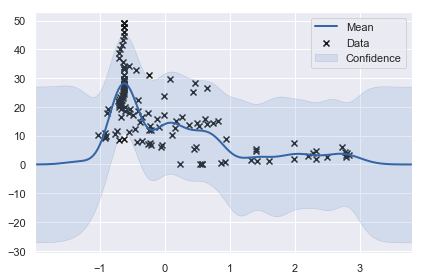

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


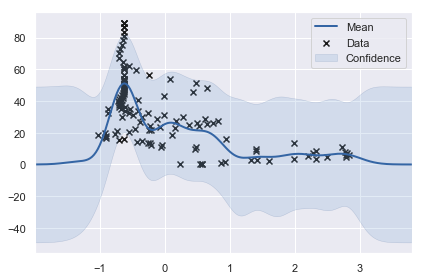

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


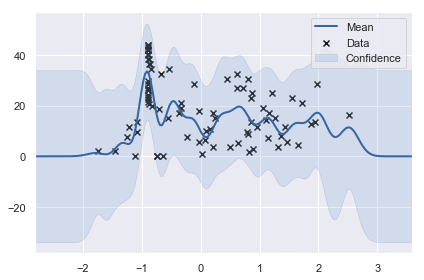

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


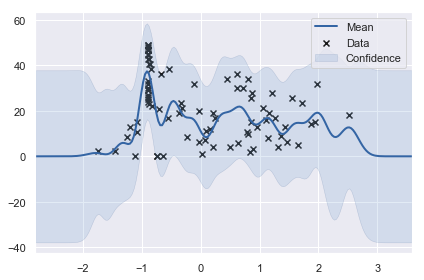

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


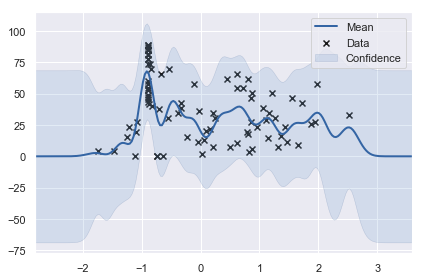

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


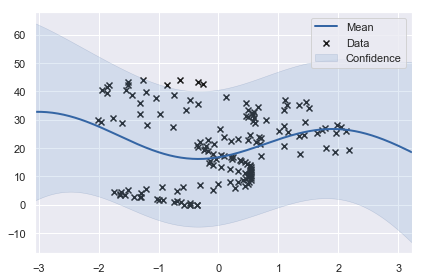

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


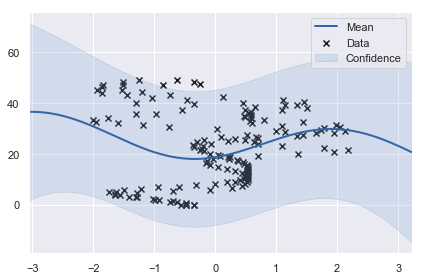

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


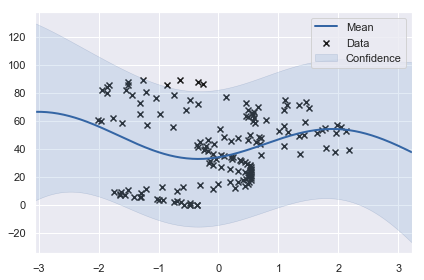

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


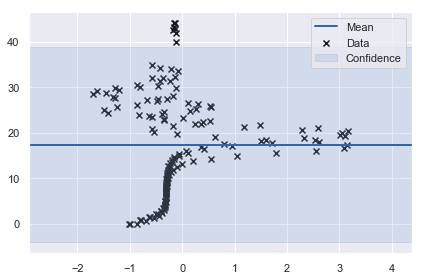

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


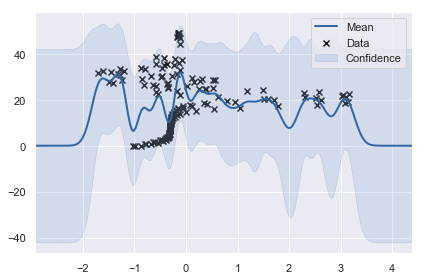

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


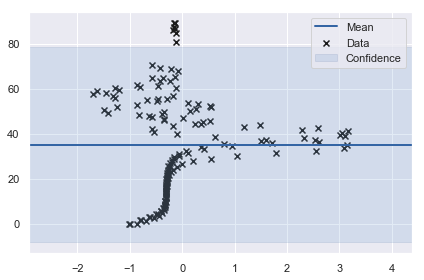

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


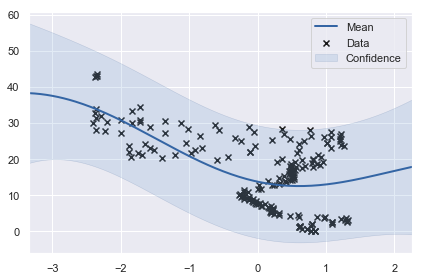

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


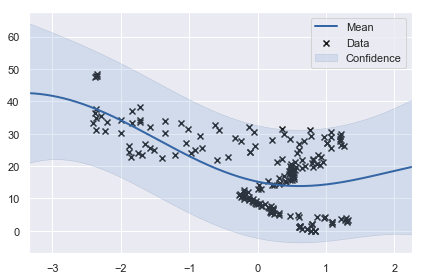

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


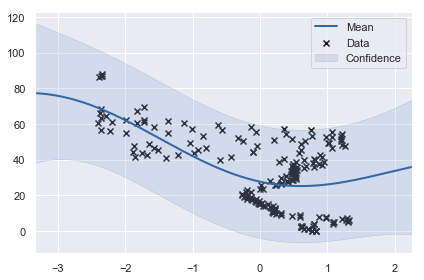

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


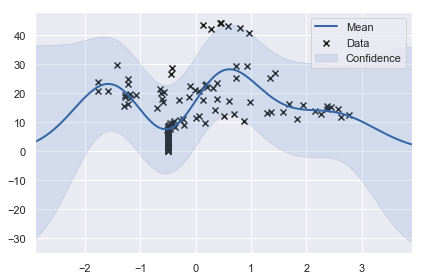

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


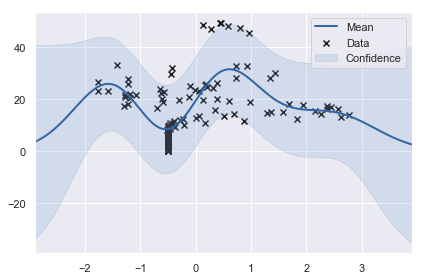

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


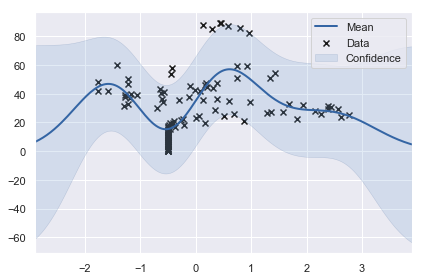

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


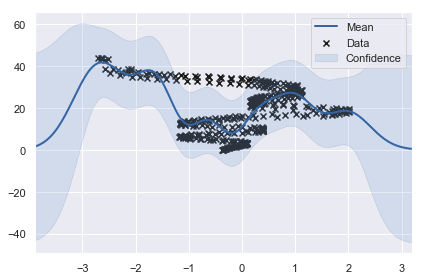

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


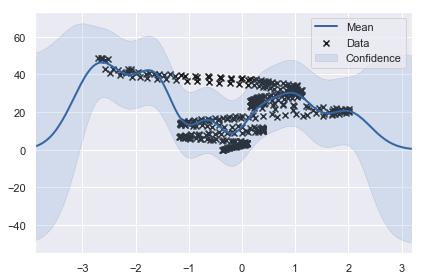

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


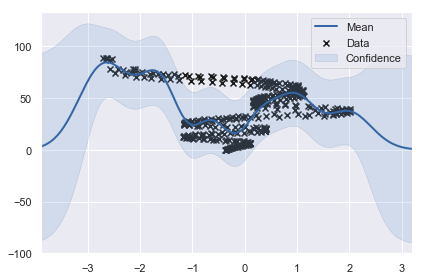

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


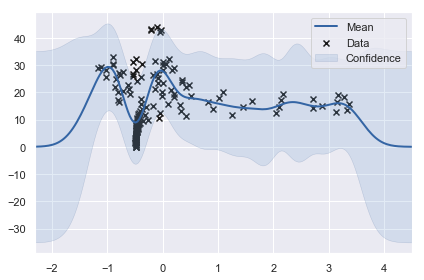

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


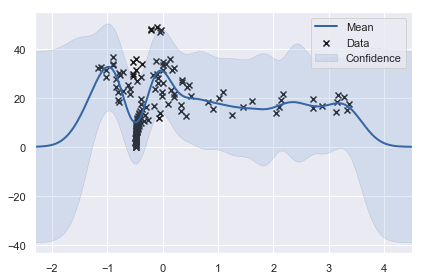

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


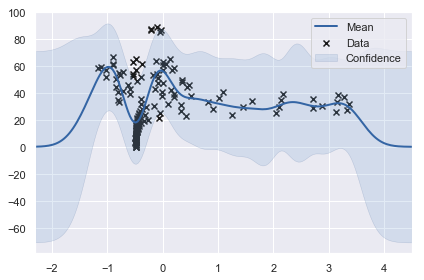

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


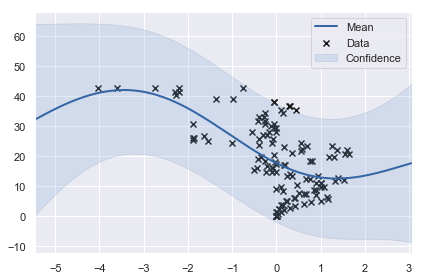

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


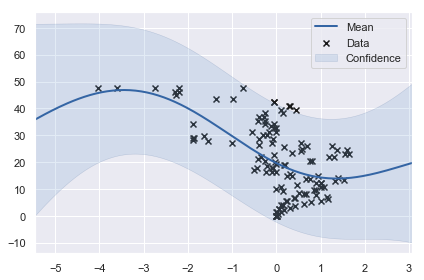

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


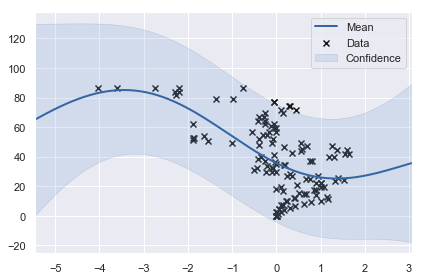

In [17]:
def synch_data(synch_gp, data):
    X = scale(data[['lat', 'lon']].values)
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    return synched_data
    
def train_gp(data, gps, route_n, traj_n, seg_n):
    seg = data[data.seg == seg_n]
    
    # Synchronise the trajectory
    synch_gp = gps[seg_n]
    synched_seg = synch_data(synch_gp, seg)
    
    # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(synched_seg, 
                     ['tau'], 
                     ['lat', 'lon'], 
                     'likelihood-v1', 
                     route_n, 
                     traj_n, 
                     seg_n)
    #gp.train(likelihood_model, 5)
    #gp.save(likelihood_model)
    
    # Learn GP to predict arrival time from synchronised trajectory
    t = travel_times[route_n][traj_n]
    synched_seg['time_remaining'] = (1 - synched_seg.progress) * t.seconds
    print(synched_seg)
    prediction_model = gp.build(synched_seg, ['tau'], ['time_remaining'], 'predict', route_n, traj_n, seg_n)
    gp.train(prediction_model, 5)
    #gp.save(prediction_model)
    gp.plot(prediction_model)
 
import plot

n_trajs = data.traj.unique()
#train_gp(data[data.seg == 2], synch_gps, route_n, synch_traj_n, 2)
#plot.traj_progress(data[data.seg == 2])
for seg_n in n_segs: 
    for traj_n in n_trajs:
        train_gp(data, synch_gps, route_n, traj_n, seg_n)


Let's plot some of the GPs for their training data to see what they look like

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


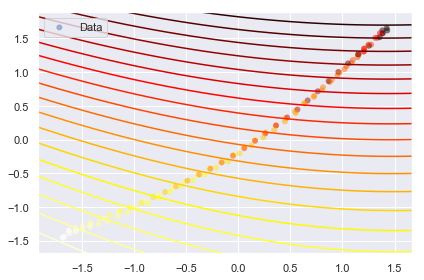

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


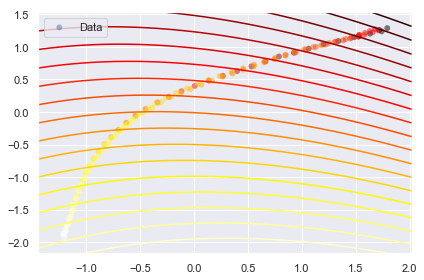

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


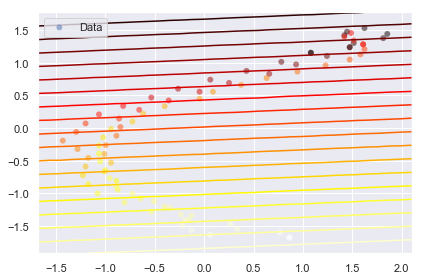

In [3]:
gp1 = gp.load(data[data.seg == 2], ['lat', 'lon'], ['progress'], 'pred-v1', route_n, synch_traj_n, 2)
gp2 = gp.load(data[data.seg == 3], ['lat', 'lon'], ['progress'], 'pred-v1', route_n, synch_traj_n, 3)
gp3 = gp.load(data[data.seg == 4], ['lat', 'lon'], ['progress'], 'pred-v1', route_n, synch_traj_n, 4)
gp.plot(gp1)
gp.plot(gp2)
gp.plot(gp3)

The results look reasonable, even though they are not amazing. It looks fairly likely that each process could have generated respective data.

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

In [4]:
# We load the parameters of the learned GPs once
learned_params = gp.load_all_params('pred-v1')
# together with the test data
test = pd.read_pickle('test.pkl')
# and the arrival times
with open('travel_times.pkl', 'rb') as handle:
    travel_times = pickle.load(handle)

In [5]:
def predict(learned_params, synch_gps, traj):
    seg_n = traj.iloc[0].seg # assume all data points are from same seg as the first
    synch_gp = synch_gps[seg_n]
    synched_traj = synch_data(synch_gp, test_traj)
    gps = most_likely_learned_gp(learned_params, synch_gp, synched_traj)
   # arrival_times[gps
   # return trajs
    #learned_trajs = [gp.build(test_traj, )]
    
def most_likely_learned_gp(learned_params, synch_gp, traj):
    mk_model = lambda r, t, s, p: gp.set_params(gp.build(traj, ['tau'], ['lat', 'lon'], 'tmp', r, t, s), p
    models = [mk_model(p) for p in learned_params]
    return sorted(models, key=gp.loglik)
    
test_trajs = test[test.seg == seg_n]
n_test_trajs = test_trajs.traj.unique()
print(n_test_trajs)
print([test_trajs[test_trajs.traj == traj_n].shape[0] for traj_n in n_test_trajs])
predictions = [predict(learned_params, synch_gps, test_trajs[test_trajs.traj == traj_n]) for traj_n in n_test_trajs]
predictions

SyntaxError: invalid syntax (<ipython-input-5-c3fbdd84f87c>, line 12)